# Hypomyelinating disorders: 
### FA-based registration pipeline for atlas-based quantitative magnetic resonance imaging (qMRI) assessment 


This nipype workflow was created to analyse pediatric qMRI images of Pelizaeus Merzbacher-Disease patients
1. the workflow registers all imaging files on the T1-weighted (t1w) image within the session 
2. patient to template registration was performed using FA-images, coregistered image files get warped to the template
3. a brain atlas segmentation from the template will transformed to the patient session space
4. processed outputfiles will appear in the derivatives folder 

In [1]:
import bids
from tqdm import tqdm
import os
from os.path import join, isfile
from nipype import Workflow
from nipype.interfaces.utility import Split, Merge
from nipype.interfaces.utility import Rename
from nipype.interfaces.io import BIDSDataGrabber, DataSink
from wmi_nipype_workflows.wmi_nipype_workflows import register_to_mni
from nipype import Node, MapNode, Workflow, IdentityInterface, Function
from nipype.interfaces.ants import N4BiasFieldCorrection
from nipype.interfaces.ants.registration import RegistrationSynQuick
from nipype.interfaces.ants.resampling import ApplyTransforms
import os
%matplotlib notebook

In [2]:
# set path for FSL, and ANTS package
os.environ["FSLDIR"] = "/opt/fsl/"
os.environ['ANTSPATH']='/opt/conda/bin/'

### select a patient-id and session-id for loading bids layout

In [3]:
subject='PMD1'
session='0m'

indexer=bids.layout.index.BIDSLayoutIndexer(validate=False, ignore=['code','tmp'])
layout = bids.BIDSLayout(os.path.dirname(os.getcwd()), derivatives=True, validate=False, indexer=indexer)

### specify imaging data for registration

In [4]:
# configure inputqueries (all modalities to register) 
# file naming and file folders must follow BIDS standard
inputqueries = {
                't1w': dict(suffix='T1w', session=session, extension='nii.gz', acquisition=None, desc=None),
                'bval': dict(suffix='dwi', session=session, extension='bval' ),
                'dwi': dict(suffix='dwi', session=session, extension='nii.gz' ),
                'fa': dict(suffix='FA', session=session, extension='nii.gz', scope='derivatives', desc=None),
                't2w': dict(suffix='T2w', session=session, extension='nii.gz', acquisition=None, desc=None),
                
         }
optional_queries={
                #'spgr': dict(suffix='T1w', session=session, extension='nii.gz', acquisition='SPGR'),
                #'mwf': dict(suffix='mwfmap', session=session, extension='nii.gz', scope='derivatives'),
                #'mrt': dict(suffix='mrtmap', session=session, extension='nii.gz', scope='derivatives'),
                #'qt1': dict(suffix='T1map', session=session, extension='nii.gz', scope='derivatives'),
                #'qt2': dict(suffix='T2map', session=session, extension='nii.gz', scope='derivatives'),
                #'mt': dict(suffix='MT', session=session, extension='nii.gz', scope='derivatives', desc=None),
                #'mtr': dict(suffix='MTR', session=session, extension='nii.gz', scope='derivatives', desc=None),
                #'ad': dict(suffix='AD', session=session, extension='nii.gz', scope='derivatives', desc=None),
                #'rd': dict(suffix='RD', session=session, extension='nii.gz', scope='derivatives', desc=None),
                #'md': dict(suffix='MD', session=session, extension='nii.gz', scope='derivatives', desc=None),
}

# define a dictionary containg the reference image as key (use same keys as in queries) for coregister session images and 
# list of maps to apply the warpfield on for the individual qMRI modality 
ref_image_matcher={'b0': ['fa'], 
                   't1w': None,
                   't2w': None,
                   #'spgr': ['mwf', 'qt1','qt2','mrt'], # mcdespot registration target (spgr) and mcdespot maps (MWF, qT1...)
                   #'mtr':['mt']                   
}

# load template as fixed (reference)images  default jhu18m 
# change the path for the T1w, T2w and a FA image as well as the atlas segmenation (mask) for using an alternativ atlas
load_fix = Node(IdentityInterface(fields=['t1','t2','fa','mask']), name='load_fix')
load_fix.inputs.t1= join(layout.root,'code','templates','JHU_pediatric','18month','JHU_pediatric18_SS_t1_ss_lps.nii.gz')
load_fix.inputs.t2= join(layout.root,'code','templates','JHU_pediatric','18month','JHU_pediatric18_SS_t2ax_ss_lps.nii.gz')
load_fix.inputs.fa= join(layout.root,'code','templates','JHU_pediatric','18month', 'JHU_pediatric18_SS_fa_ss_lps.nii.gz')
load_fix.inputs.mask= join(layout.root,'code','templates','JHU_pediatric','18month','dil_ventricle_atlas18m.nii.gz')



In [5]:
# load files for every patient
in_files = {}
queries= inputqueries
queries.update(optional_queries)   
### STEP 1 coregistrater files within the session ####
inputnode = Node(IdentityInterface(list(queries.keys())), name='inputnode')
for key in queries.keys():
        # load input files according to dict
    in_files[key] = layout.get(**queries[key], return_type='file', subject=subject, invalid_filters='allow')
    inputnode.set_input(key, in_files[key])

### check if imaging data was correcty set in inputnode
One file per inputfield

In [6]:
# files found as specified for the inputnode
print(f'found files of subject: {subject}, session: {session} for co-registration to t1w image')
inputnode.inputs

found files of subject: PMD1, session: 0m for co-registration to t1w image



bval = ['/home/jovyan/work/atlas-based-assessment-of-hypomyelination/sub-PMD1/ses-0m/dwi/sub-PMD1_ses-0m_dwi.bval']
dwi = ['/home/jovyan/work/atlas-based-assessment-of-hypomyelination/sub-PMD1/ses-0m/dwi/sub-PMD1_ses-0m_dwi.nii.gz']
fa = ['/home/jovyan/work/atlas-based-assessment-of-hypomyelination/derivatives/DWI/sub-PMD1/ses-0m/sub-PMD1_ses-0m_FA.nii.gz']
t1w = ['/home/jovyan/work/atlas-based-assessment-of-hypomyelination/sub-PMD1/ses-0m/anat/sub-PMD1_ses-0m_T1w.nii.gz']
t2w = ['/home/jovyan/work/atlas-based-assessment-of-hypomyelination/sub-PMD1/ses-0m/anat/sub-PMD1_ses-0m_T2w.nii.gz']

In [7]:
#squeeze= remove list from loaded files
for q in list(queries.keys()):
    squeezer= f'{q}_squeezer'
        
    globals()[squeezer]= Node(Split(splits=[1], squeeze=True), name= f'{q}_squeezer')
    #t1w_squeezer = Node(Split(splits=[1], squeeze=True), name='t1w_squeezer')

In [8]:
flat_list = []
for xs in list(ref_image_matcher.keys()):
    flat_list.append(xs)
    for x in list(ref_image_matcher.values()):
        if x is not None:
            for v in x:

                flat_list.append(v)
flat_list=list(set(flat_list))
flat_list

['b0', 't2w', 'fa', 't1w']

In [9]:
from wmi_nipype_workflows.wmi_nipype_workflows.brainextract_workflow import brain_extraction_wf
from nipype.interfaces.fsl.maths import ApplyMask
from nipype.interfaces.fsl import ImageMaths
from nipype.interfaces.fsl import BET
from nipype.interfaces.ants import N4BiasFieldCorrection
# brainextraction workflow --> robustvov get biascorrected T1w image 
brain_ex_t1 = brain_extraction_wf(report_dir=join(layout.root,'tmp','wmi_workflow_report'))
robustfov = brain_ex_t1.get_node('robustfov')
#bet = Node(BET(robust=True, mask=True, frac= 0.5), name='bet')
#bias_correction = Node(N4BiasFieldCorrection(), name="bias_correction" )


In [10]:
# get registration target spgrfa18 for registration of resulting mcdespot maps 
from dwi_target import get_dwi_target, get_mwf_target
mwf_target = get_mwf_target()

In [11]:
# generate a b0 image
b0_sink = Node(DataSink(base_directory=join(layout.root, 'derivatives', 'b0'),
                                     remove_dest_dir=True,
                                     parameterization=False),
                                     name='b0_sink')
b0_sink.inputs.container=join('sub-'+subject, 'ses-'+session)
                
# calculate b0 image for fa registration
from dti_b0 import b0_average
avg_b0 = Node(Function(input_names=['in_dwi', 'in_bval'],
                            output_names=['out_file'],
                            function=b0_average),
                         name='b0_avg')
rename_b0 = Node(Rename(format_string=("sub-{subject}_ses-{session}_space-{session}_b0"),
                                 keep_ext=True),
                          name='rename_b0')
rename_b0.inputs.subject_id= subject
rename_b0.inputs.session_id= session

In [12]:
coreg_sink = Node(DataSink(base_directory=join(layout.root,'derivatives', 'coreg_session'),
                                    remove_dest_dir=True,
                                    parameterization=False),
                            name='coreg_sink')         
coreg_sink.inputs.container=join('sub-'+subject, 'ses-'+session)

In [13]:
# nodes for coregister session 
for ref in list(ref_image_matcher.keys()):
    coreg= f'{ref}_coreg'
    rename_affine= f'{ref}_rename_affine'
    # nodes for coregister session 
    globals()[coreg]= Node(RegistrationSynQuick(transform_type="r"), name=f'{ref}_coreg')
    # nods for rename and save affine matrix from coregister session
    globals()[rename_affine]= Node(Rename(format_string=(f"sub-{subject}_ses-{session}_space-from{ref}_to_sessiont1w_xfm"),
                          keep_ext=True), name=f'{ref}_rename_affine')
    globals()[rename_affine].inputs.subject_id= subject
    globals()[rename_affine].inputs.session_id= session 

In [14]:
# nodes for apply warp to quantitative maps
for ref in list(ref_image_matcher.keys()):
    if ref_image_matcher[ref] is not None:
        for qmrimap in ref_image_matcher[ref]: 
            applyw= f'{qmrimap}_applyw'
            globals()[applyw]= Node(ApplyTransforms(), name=f'{qmrimap}_applyw')

In [15]:
# flatten list for ref_image_matcher.items()
flat_list = []

for xs in list(ref_image_matcher.keys()):
    flat_list.append(xs)
    #print(flat_list)
    for x in list(ref_image_matcher.values()):
        if x is not None:
            for v in x:
                #print('v', v)
                flat_list.append(v)
                #print(flat_list)
        
flat_list=list(set(flat_list))

In [16]:
# adjust for different Image Dimension, otherwise brain mask cant be applied
from nilearn.image import resample_to_img
# create Node for resample all images to apply brainmask
def resampling(target, in_file): 
    import nibabel as nib
    from nilearn.image import resample_to_img
    from os.path import abspath, dirname, basename
    out_file = abspath('resampled_'+basename(in_file))
    resampled = resample_to_img(source_img=in_file, target_img=target)
    nib.save(resampled, out_file)
    return out_file

    
for image in flat_list:
    resample= f'{image}_resample'
    globals()[resample] = Node(Function(function=resampling,
                                       input_names=["target", "in_file"],
                                       output_names=["out_file"]),
                            name=f'{image}_resample')

In [17]:
## Apply the brainmask to the images which are registered within session
for image in flat_list:
    applymask= f'{image}_applymask'
    globals()[applymask] = Node(ApplyMask(), name=f'{image}_applymask')

In [18]:
for name in flat_list:
    rename= f'{name}_rename'
    globals()[rename]= Node(Rename(format_string=(f"sub-{subject}_ses-{session}_space-t1w_desc-brainextracted_{name}"),
                          keep_ext=True), name=f'{name}_rename')
    globals()[rename].inputs.subject_id= subject
    globals()[rename].inputs.session_id= session 
 

### STEP1: connect nodes to register files within the session on T1-weighted image

In [19]:
tmp = join(layout.root, 'tmp','fa', f'sub-{subject}', f'ses-{session}')
wf = Workflow(name='coreg_pmd', base_dir=tmp)
# load files and remove list (squeeze)
for qname in list(queries.keys()):
    if qname == 'spgr':
        wf.connect( [(inputnode, globals()[f'{qname}_squeezer'], [(f'{qname}','inlist')]),
                     #extract spgrfa18 from 4d file
                     (spgr_squeezer, mwf_target, [('out1', 'inputnode.in_file')]),
                  ])   
    else:
        wf.connect( [(inputnode, globals()[f'{qname}_squeezer'], [(f'{qname}','inlist')]),
         #[(inputnode, globals()[f'{qname}_squeezer'], [('t1w','inlist')]),
          ])
wf.connect( 
            # connect t1w image with brain extraction workflow use robustfov image as fixed image
            [(t1w_squeezer, brain_ex_t1, [('out1', 'inputnode.in_file')]),

             
             # b0 image calcuation for regsitering FA maps...
             (bval_squeezer, avg_b0, [('out1', 'in_bval')]),
             (dwi_squeezer, avg_b0, [('out1', 'in_dwi')]),
             (avg_b0, rename_b0, [('out_file', 'in_file')]),
             (rename_b0, b0_sink, [('out_file', '@b0')]),
             
 
            ])
# step 1 register images within the session to t1w image
for ref in list(ref_image_matcher.keys()):
    wf.connect( [( robustfov, globals()[f'{ref}_coreg'], [('out_roi','fixed_image')]),  

                 
                ])
    if ref=='spgr':
        wf.connect( [(mwf_target, spgr_coreg, [('outputnode.spgr_target','moving_image')]),
                    (spgr_coreg, spgr_rename_affine, [('out_matrix', 'in_file')]),
                    (spgr_rename_affine, coreg_sink, [('out_file', f'xfm.@spgr')]),
                    ])   
    elif ref=='b0':
        wf.connect( [(avg_b0, b0_coreg, [('out_file','moving_image')]),
                    (b0_coreg, b0_rename_affine, [('out_matrix', 'in_file')]),
                    (b0_rename_affine, coreg_sink, [('out_file', f'xfm.@b0')]),
                    ])       
    else:
        wf.connect( [(globals()[f'{ref}_squeezer'], globals()[f'{ref}_coreg'], [('out1','moving_image')]),
                     (globals()[f'{ref}_coreg'], globals()[f'{ref}_rename_affine'], [('out_matrix','in_file')]),
                     (globals()[f'{ref}_rename_affine'], coreg_sink, [('out_file', f'xfm.@{ref}')]),
                ])
# apply individual warpfields to qmri maps corresponding to ref_image_matcher 
for ref in list(ref_image_matcher.keys()):
    if ref_image_matcher[ref] is not None:
        for qmrimap in ref_image_matcher[ref]: 
            wf.connect( [( globals()[f'{ref}_coreg'], globals()[f'{qmrimap}_applyw'], [('out_matrix', 'transforms')]),
                         ( t1w_squeezer, globals()[f'{qmrimap}_applyw'], [('out1', 'reference_image')]),
                         ( globals()[f'{qmrimap}_squeezer'], globals()[f'{qmrimap}_applyw'], [('out1', 'input_image')]),

                        ])

for name in flat_list:                         
    if  name in list(ref_image_matcher.keys()):
       # resample ref_images
        wf.connect( [(globals()[f'{name}_coreg'], globals()[f'{name}_resample'], [('warped_image', 'in_file')]), 
                     (t1w_squeezer, globals()[f'{name}_resample'], [('out1', 'target')]),
                      ])
    else: # resample all maps                     
        wf.connect( [(globals()[f'{name}_applyw'], globals()[f'{name}_resample'], [('output_image', 'in_file')]),
                     (t1w_squeezer, globals()[f'{name}_resample'], [('out1', 'target')]),
                    ])
# apply brainmask to all images
for name in flat_list:  
    wf.connect( [   
                     (globals()[f'{name}_resample'],globals()[f'{name}_applymask'], [('out_file', 'in_file')]), 
                         
                          #(bet, globals()[f'{qmrimap}_applymask'], [('mask_file', 'mask_file')]),
                         (brain_ex_t1, globals()[f'{name}_applymask'], [('outputnode.mask', 'mask_file')]),
                         
                         (globals()[f'{name}_applymask'],globals()[f'{name}_rename'], [('out_file', 'in_file')]), 
                         #(globals()[f'{qmrimap}_resample'], globals()[f'{qmrimap}_rename'], [('out_file', 'in_file')]), 
                         (globals()[f'{name}_rename'], coreg_sink, [('out_file', f'anat.@{name}')]),
                ])  

In [20]:
# run nodes for registration workkflow step 1
wf.run()

240131-13:09:13,698 nipype.workflow INFO:
	 Workflow coreg_pmd settings: ['check', 'execution', 'logging', 'monitoring']
240131-13:09:13,882 nipype.workflow INFO:
	 Running serially.
240131-13:09:13,884 nipype.workflow INFO:
	 [Node] Setting-up "coreg_pmd.t1w_squeezer" in "/home/jovyan/work/atlas-based-assessment-of-hypomyelination/tmp/fa/sub-PMD1/ses-0m/coreg_pmd/t1w_squeezer".
240131-13:09:13,887 nipype.workflow INFO:
	 [Node] Cached "coreg_pmd.t1w_squeezer" - collecting precomputed outputs
240131-13:09:13,888 nipype.workflow INFO:
	 [Node] "coreg_pmd.t1w_squeezer" found cached.
240131-13:09:13,889 nipype.workflow INFO:
	 [Node] Setting-up "coreg_pmd.bval_squeezer" in "/home/jovyan/work/atlas-based-assessment-of-hypomyelination/tmp/fa/sub-PMD1/ses-0m/coreg_pmd/bval_squeezer".
240131-13:09:13,892 nipype.workflow INFO:
	 [Node] Cached "coreg_pmd.bval_squeezer" - collecting precomputed outputs
240131-13:09:13,892 nipype.workflow INFO:
	 [Node] "coreg_pmd.bval_squeezer" found cached.
240

### co-registered files are saved in derivatives/coreg_session

In [21]:
# create a dataset_description.json for derivatives 'coreg_session'
import time
import json
__version__ = "0.2"
with open(join(layout.root, 'derivatives', 'coreg_session', 'dataset_description.json'), 'w') as f:
    f.write(json.dumps({
        'Name': 'register session files on t1w image',
        'BIDSVersion': '1.4.0',
        'DatasetType': 'derivative',
        'GeneratedBy': [{'caroline.koehler@ukdd.de': 'co-register session images to T1-weighted image of the session'}]
    }))

with open(join(layout.root, 'derivatives', 'coreg_session', 'CHANGELOG'), 'a') as f:
    f.write('\n')
    f.write(time.strftime("%Y-%m-%d:"))
    f.write('\t-Running reg_session Workflow')
# update layout otherwise coreg_session files are not found)

try:
    layout.add_derivatives(path= join(layout.root, 'derivatives', 'coreg_session'))
    print ('writing dataset_description for derivatives coreg_session')

except:
    print('dataset_description exists ')

dataset_description exists 


### Step2: Register patient data to template and warp back atlas segmetation in patient space using FA-based registration

In [22]:
print('warp atlas in PMD space')
### STEP2: warp the jhu18m atlas in pmd patient space ###
print('reload bids layout')
layout2 = bids.BIDSLayout(layout.root, derivatives=True, validate=False, ignore=['code','tmp', 'tmp_t1w','tmp_fa','tmp_multimod'])

warp atlas in PMD space
reload bids layout


/opt/conda/lib/python3.9/site-packages/bids/layout/validation.py:48: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "


In [23]:
load_coreg = Node(IdentityInterface(flat_list), name='inputnode2')
for name in flat_list:
    in_files= layout2.get(suffix=name, subject=subject, session=session, acquisition=None, scope='derivatives', desc='brainextracted', extension='nii.gz')
    load_coreg.set_input(name, in_files)

In [24]:
# shows all found coregistered and brainextracted images of the subject and session
print(f'list of files found for registration step 2 of subject:{subject}' )
load_coreg.inputs

list of files found for registration step 2 of subject:PMD1



b0 = [<BIDSImageFile filename='/home/jovyan/work/atlas-based-assessment-of-hypomyelination/derivatives/coreg_session/sub-PMD1/ses-0m/anat/sub-PMD1_ses-0m_space-t1w_desc-brainextracted_b0.nii.gz'>]
fa = [<BIDSImageFile filename='/home/jovyan/work/atlas-based-assessment-of-hypomyelination/derivatives/coreg_session/sub-PMD1/ses-0m/anat/sub-PMD1_ses-0m_space-t1w_desc-brainextracted_fa.nii.gz'>]
t1w = [<BIDSImageFile filename='/home/jovyan/work/atlas-based-assessment-of-hypomyelination/derivatives/coreg_session/sub-PMD1/ses-0m/anat/sub-PMD1_ses-0m_space-t1w_desc-brainextracted_t1w.nii.gz'>]
t2w = [<BIDSImageFile filename='/home/jovyan/work/atlas-based-assessment-of-hypomyelination/derivatives/coreg_session/sub-PMD1/ses-0m/anat/sub-PMD1_ses-0m_space-t1w_desc-brainextracted_t2w.nii.gz'>]

In [25]:
# create multiple nodes squeeze= remove list from loaded files
for q in flat_list:
    squeez= f'{q}_squeez'
    globals()[squeez]= Node(Split(splits=[1], squeeze=True), name= f'{q}_squeez')

In [26]:
# merge files to list
merge_inputs=len(flat_list)# dynamic number of connections in for merge node
pmd_coregimages=Node(Merge(merge_inputs), name='pmd_coregimages') # make a list of images to use Mapnodes 

In [27]:
# apply inverse warp field on jhu atlas/ mask
# this workflow register the moving image to a template (reference image) and apply an inverse transform to the atlas segmentation
# this warps the altas segmentation in the patient session space 
# Additionally, pmd_coreg_images get warped to jhu template
from wmi_nipype_workflows.wmi_nipype_workflows.register_to_mni import mask_to_patient_space
mask_to_pmd = mask_to_patient_space()

In [28]:
# split inv_mask because it is a list (mapnode)
split_inv_mask= Node(Split(), name= 'split_inv_mask')
split_inv_mask.inputs.splits= [1]
split_inv_mask.inputs.squeeze= True

In [29]:
# apply transforms on pmd_coregimages
# all coregistered files are also moved to template space fascilitating patient comparison
from nipype.interfaces.ants import ApplyTransforms, RegistrationSynQuick
apply_transforms_forw= MapNode(ApplyTransforms(), name = 'apply_transforms_forw', iterfield = ['input_image'])
transforms = Node(Merge(2), name='transforms')
split_pmd_forw = Node(Split(), name= 'split_pmd_forw')
split_pmd_forw.inputs.splits= [1]*merge_inputs
split_pmd_forw.inputs.squeeze= True

In [30]:
# rename and save jhu18m atlas/mask in pmd space
jhu_to_pmd_fa = Node(DataSink(base_directory=join(layout.root,'derivatives', 'jhu18m_to_pmd_fa'),
                           remove_dest_dir=True,
                            parameterization=False), name='jhu_to_pmd_fa')
jhu_to_pmd_fa.inputs.container=join('sub-'+subject, 'ses-'+session) 

rename_atlas = Node(Rename(format_string=("sub-%(subject_id)s_ses-%(session_id)s_space-%(session_id)s_desc-jhu18m_label-regfa_mask"),
                        keep_ext=True),
                        name='rename_atlas')
rename_atlas.inputs.subject_id= subject
rename_atlas.inputs.session_id= session

coreg_jhu_fa = Node(DataSink(base_directory=join(layout.root,'derivatives', 'coreg_jhu_fa'),
                                 remove_dest_dir=True,
                                 parameterization=False), name='coreg_jhu_fa')
coreg_jhu_fa.inputs.container=join('sub-'+subject, 'ses-'+session) 

In [31]:
for name in flat_list:
    rename= f'{name}_rename_jhu'
    globals()[rename]= Node(Rename(format_string=(f"sub-{subject}_ses-{session}_space-jhu_desc-regFA_{name}"),
                          keep_ext=True), name=f'{name}_rename_jhu')
    globals()[rename].inputs.subject_id= subject
    globals()[rename].inputs.session_id= session 

In [32]:
# warp files to register fa from pmd space to jhu18m atlas space
rename_jhu_affine = Node(Rename(format_string=(f"sub-{subject}_ses-{session}_from-pmdfa_to-jhufa_desc-affine_xfm"),
                        keep_ext=True),
           name='rename_jhu_affine')
rename_jhu_affine.inputs.subject_id= subject
rename_jhu_affine.inputs.session_id= session

rename_jhu_forwardwarp = Node(Rename(format_string=(f"sub-{subject}_ses-{session}_from-pmdfa_to-jhufa_desc-forward_xfm"),
                         keep_ext=True),
  name='rename_jhu_forwardwarp')
rename_jhu_forwardwarp.inputs.subject_id= subject
rename_jhu_forwardwarp.inputs.session_id= session

rename_jhu_invwarp = Node(Rename(format_string=(f"sub-{subject}_ses-{session}_from-pmdfa_to-jhufa_desc-inverse_xfm"),
                       keep_ext=True),
           name='rename_jhu_invwarp')
rename_jhu_invwarp.inputs.subject_id= subject
rename_jhu_invwarp.inputs.session_id= session            

In [33]:
#connect the nodes for registration step 2
tmp = join(layout.root, 'tmp','fa', f'sub-{subject}', f'ses-{session}')
wf = Workflow(name='mask_to_patient_space_fa', base_dir=tmp)

wf.connect([(load_coreg, fa_squeez , [('fa', 'inlist')]),
            ])

# merge all coregistered files in a list except registration target 
#for count, name in enumerate(list(filter(lambda x: x != 'fa', flat_list))):
for count, name in enumerate(flat_list):
    wf.connect([(load_coreg, pmd_coregimages, [(name, f'in{count+1}')])
                ])
wf.connect([(load_fix, mask_to_pmd, [('fa', 'inputnode.fixed_image')]),
            # fa registration pmd to jhu18m, apply inv warp to altas and save atlas in pmd space 
            (fa_squeez, mask_to_pmd, [('out1', 'inputnode.moving_image')]),   
                        (load_fix, mask_to_pmd, [('mask', 'inputnode.mask')]),   
                        (mask_to_pmd, split_inv_mask, [('outputnode.inv_mask', 'inlist')]),  
                        (split_inv_mask, rename_atlas, [('out1', 'in_file')]),  
                        (rename_atlas, jhu_to_pmd_fa, [('out_file', '@atlas')]),
            # apply registration on PMD coregimages to jhu space
                        (mask_to_pmd, transforms, [('outputnode.affine_matrix', 'in2'),
                                                   ('outputnode.forward_warp_field', 'in1')]),
                        (transforms, apply_transforms_forw, [('out', 'transforms')]),
                        (pmd_coregimages, apply_transforms_forw, [('out', 'input_image')]),
                        (load_fix, apply_transforms_forw, [('fa', 'reference_image')]),  
                        (apply_transforms_forw, split_pmd_forw, [('output_image', 'inlist')]),
        ])
# save and rename coregimages in jhu space
for count, name in enumerate(flat_list):
    wf.connect([(split_pmd_forw, globals()[f'{name}_rename_jhu'], [(f'out{count+1}', 'in_file')]),
                (globals()[f'{name}_rename_jhu'], coreg_jhu_fa , [('out_file', f'anat.@{name}')]),
               ])
# save warpfiles for  registration from pmd to jhu space 
wf.connect([(mask_to_pmd, rename_jhu_affine, [('outputnode.affine_matrix', 'in_file')]),
            (rename_jhu_affine, coreg_jhu_fa , [('out_file', 'xfm.@multimod')]),
            (mask_to_pmd, rename_jhu_forwardwarp, [('outputnode.forward_warp_field', 'in_file')]),
            (rename_jhu_forwardwarp, coreg_jhu_fa , [('out_file', 'xfm.@forward')]),
            (mask_to_pmd, rename_jhu_invwarp, [('outputnode.inverse_warp_field', 'in_file')]),
            (rename_jhu_invwarp, coreg_jhu_fa , [('out_file', 'xfm.@inverse')]),
           ])       

In [34]:
# start the registration pipeline
wf.run()

240131-13:09:16,671 nipype.workflow INFO:
	 Workflow mask_to_patient_space_fa settings: ['check', 'execution', 'logging', 'monitoring']
240131-13:09:16,745 nipype.workflow INFO:
	 Running serially.
240131-13:09:16,747 nipype.workflow INFO:
	 [Node] Setting-up "mask_to_patient_space_fa.fa_squeez" in "/home/jovyan/work/atlas-based-assessment-of-hypomyelination/tmp/fa/sub-PMD1/ses-0m/mask_to_patient_space_fa/fa_squeez".
240131-13:09:16,750 nipype.workflow INFO:
	 [Node] Cached "mask_to_patient_space_fa.fa_squeez" - collecting precomputed outputs
240131-13:09:16,751 nipype.workflow INFO:
	 [Node] "mask_to_patient_space_fa.fa_squeez" found cached.
240131-13:09:16,752 nipype.workflow INFO:
	 [Node] Setting-up "mask_to_patient_space_fa.pmd_coregimages" in "/home/jovyan/work/atlas-based-assessment-of-hypomyelination/tmp/fa/sub-PMD1/ses-0m/mask_to_patient_space_fa/pmd_coregimages".
240131-13:09:16,755 nipype.workflow INFO:
	 [Node] Outdated cache found for "mask_to_patient_space_fa.pmd_coregima

### jhu18m mask is warped in patient space derivatives/jhu18m_to_pmd_fa

In [35]:
# create a dataset_description.json for derivatives 'jhu18m_to_pmd_fa'
import time
import json
__version__ = "0.2"
with open(join(layout.root, 'derivatives', 'jhu18m_to_pmd_fa', 'dataset_description.json'), 'w') as f:
    f.write(json.dumps({
                'Name': 'register session files to template using fa images',
                'BIDSVersion': '1.4.0',
                'DatasetType': 'derivative',
                'GeneratedBy': [{'caroline.koehler@ukdd.de': 'FA-based template registration'}]
                
    }))

with open(join(layout.root, 'derivatives', 'jhu18m_to_pmd_fa', 'CHANGELOG'), 'a') as f:
    f.write('\n')
    f.write(time.strftime("%Y-%m-%d:"))
    f.write('\t-Running reg_template Workflow')
# update layout otherwise jhu18m_to_pmd_fa files are not found)
try:
    layout.add_derivatives(path= join(layout.root, 'derivatives', 'jhu18m_to_pmd_fa'))
    print ('writing dataset_description for derivatives jhu18m_to_pmd_fa')

except:
    print('dataset_description exists ')

dataset_description exists 


### MRI data is warped in template space using FA images derivatives/coreg_jhu_fa

In [36]:
import time
import json
__version__ = "0.2"
with open(join(layout.root, 'derivatives', 'coreg_jhu_fa', 'dataset_description.json'), 'w') as f:
    f.write(json.dumps({
                'Name': 'register session files to template using fa images',
                'BIDSVersion': '1.4.0',
                'DatasetType': 'derivative',
                'GeneratedBy': [{'caroline.koehler@ukdd.de': 'FA-based template registration'}]
    }))

with open(join(layout.root, 'derivatives', 'coreg_jhu_fa', 'CHANGELOG'), 'a') as f:
    f.write('\n')
    f.write(time.strftime("%Y-%m-%d:"))
    f.write('\t-Running reg_template Workflow')
# update layout otherwise jhu18m_to_pmd_fa files are not found)
try:
    layout.add_derivatives(path= join(layout.root, 'derivatives', 'jhu18m_to_pmd_fa'))
    print ('writing dataset_description for derivatives jhu18m_to_pmd_fa')

except:
    print('dataset_description exists ')

dataset_description exists 


### A nipype workflow is illustrated for template registration (step 2)

240131-13:09:29,432 nipype.workflow INFO:
	 Generated workflow graph: /home/jovyan/work/atlas-based-assessment-of-hypomyelination/fa_based_template_registration_workflow.png (graph2use=hierarchical, simple_form=False).


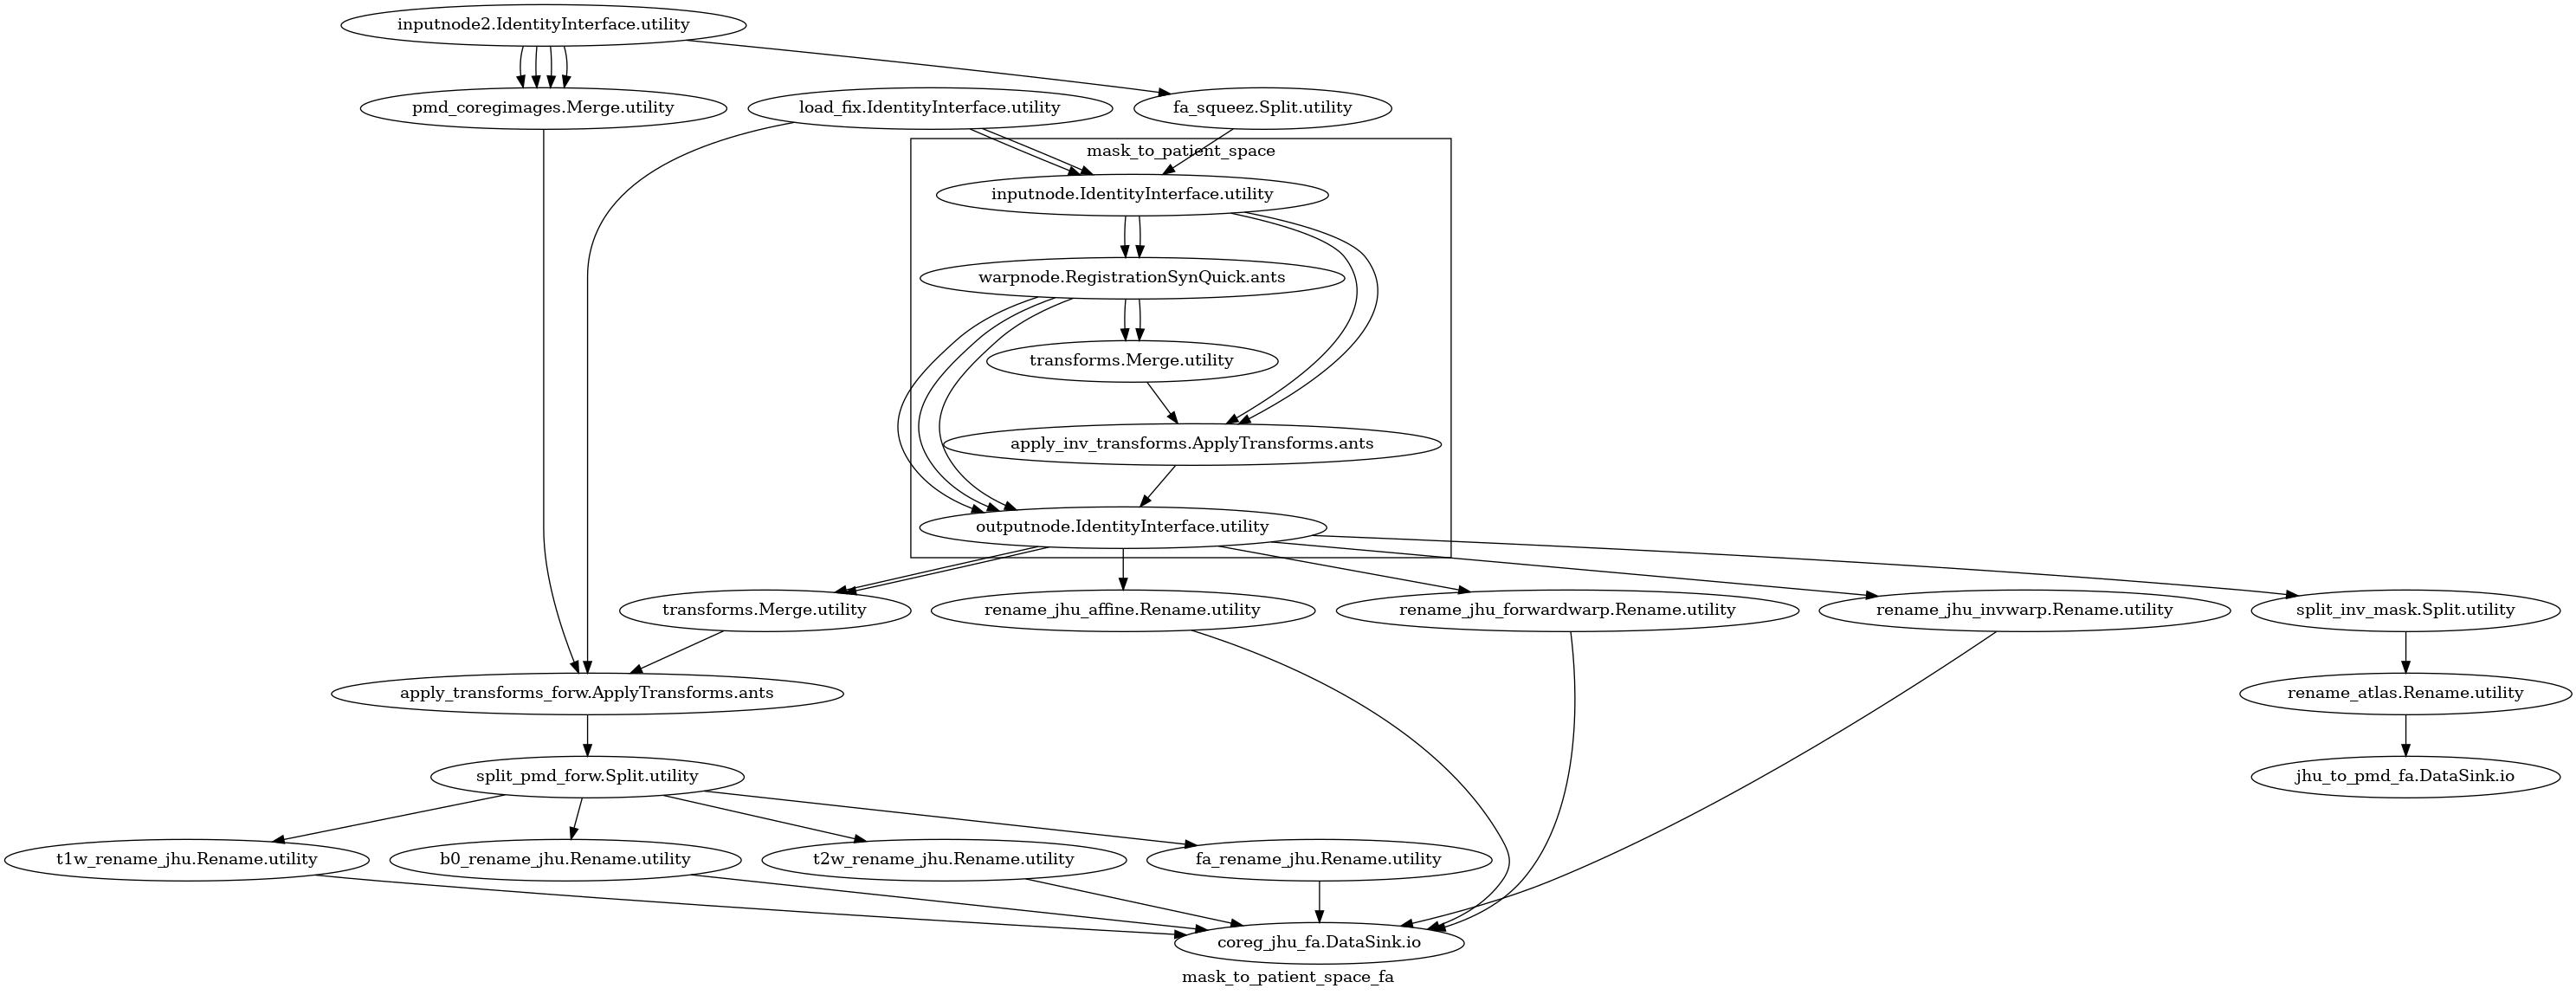

In [37]:

wf.write_graph(dotfilename=join(layout.root,'fa_based_template_registration_workflow.dot'), format='png', simple_form=False)
from IPython.display import Image
Image(filename=join(layout.root,'fa_based_template_registration_workflow.png'))